<a href="https://colab.research.google.com/github/hkane206/EnergyPolicy/blob/main/res_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Packages**

In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# **Pre-Processing**

In [ ]:
# From before: read in csv and classify renewable vs nonrenewable energy sources
energy_production = pd.read_csv("/content/organised_Gen.csv")
energy_production.drop(['Unnamed: 0', 'TYPE OF PRODUCER'], axis=1, inplace=True)

renewable_energy_sources = ["Hydroelectric Conventional", "Wind", "Wood and Wood Derived Fuels", "Other Biomass", "Solar Thermal and Photovoltaic", "Geothermal"]
nonrenewable_energy_sources = ["Coal", "Petroleum", "Natural Gas", "Nuclear"]

energy_production["RENEWABLE"] = np.where(energy_production["ENERGY SOURCE"].isin(renewable_energy_sources), "Renewable",
                                 np.where(energy_production["ENERGY SOURCE"].isin(nonrenewable_energy_sources), "Nonrenewable", "Other"))

In [ ]:
# For time series analysis, create DATE column

energy_production['DATE'] = pd.to_datetime(energy_production['YEAR'].astype(str) + '-' + energy_production['MONTH'].astype(str).str.zfill(2) + '-01')
energy_production = energy_production.sort_values('DATE')

grouped_ep = energy_production.groupby(['STATE', 'DATE', 'RENEWABLE'])['GENERATION (Megawatthours)'].sum().unstack()
grouped_ep['RES'] = 100 * grouped_ep['Renewable']/(grouped_ep['Nonrenewable']+grouped_ep['Renewable']).replace(0,1)

grouped_ep.head()

RENEWABLE         Nonrenewable      Other  Renewable        RES
STATE DATE                                                     
AK    2001-01-01      971018.0  1180290.0   209272.0  17.730558
      2001-02-01      911964.0  1092334.0   180370.0  16.512349
      2001-03-01      974382.0  1174230.0   199848.0  17.019494
      2001-04-01      808024.0   977396.0   169372.0  17.328903
      2001-05-01      798976.0   969374.0   170398.0  17.578148

# **Visualize Time Series Plots**

<Figure size 1200x600 with 0 Axes>

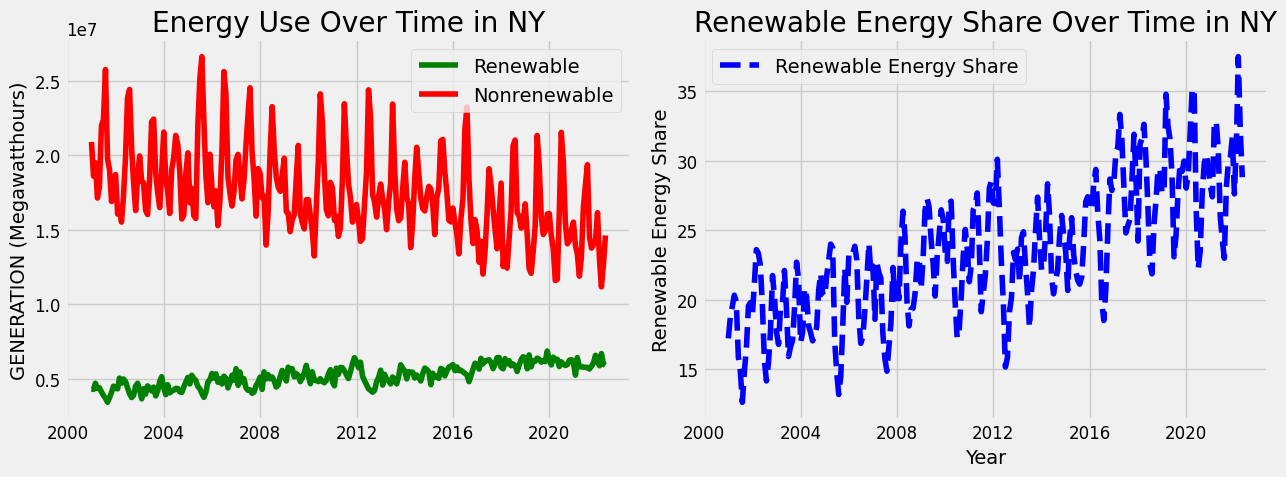

In [ ]:
state = "NY"
# Filter data for state
state_data = grouped_ep.xs(key=state, level='STATE')

# Plot
plt.figure(figsize=(12, 6))

# Create a 2-row figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5), sharex=True)


# Plot renewable and nonrenewable on the top plot
if 'Renewable' in state_data.columns:
    ax1.plot(state_data.index, state_data['Renewable'], label='Renewable', color='green')

if 'Nonrenewable' in state_data.columns:
    ax1.plot(state_data.index, state_data['Nonrenewable'], label='Nonrenewable', color='red')

ax1.set_title('Energy Use Over Time in ' + state)
ax1.set_ylabel('GENERATION (Megawatthours)')
ax1.grid(True)
ax1.legend()


# Plot the ratio on the bottom plot
ax2.plot(state_data.index, state_data['RES'], label='Renewable Energy Share', color='blue', linestyle='--')
ax2.set_title('Renewable Energy Share Over Time in ' + state)
ax2.set_xlabel('Year')
ax2.set_ylabel('Renewable Energy Share')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Filter out data after 2019 because of COVID
state_data = state_data[state_data.index.year <= 2019]

# **Time-Series Decomposition**

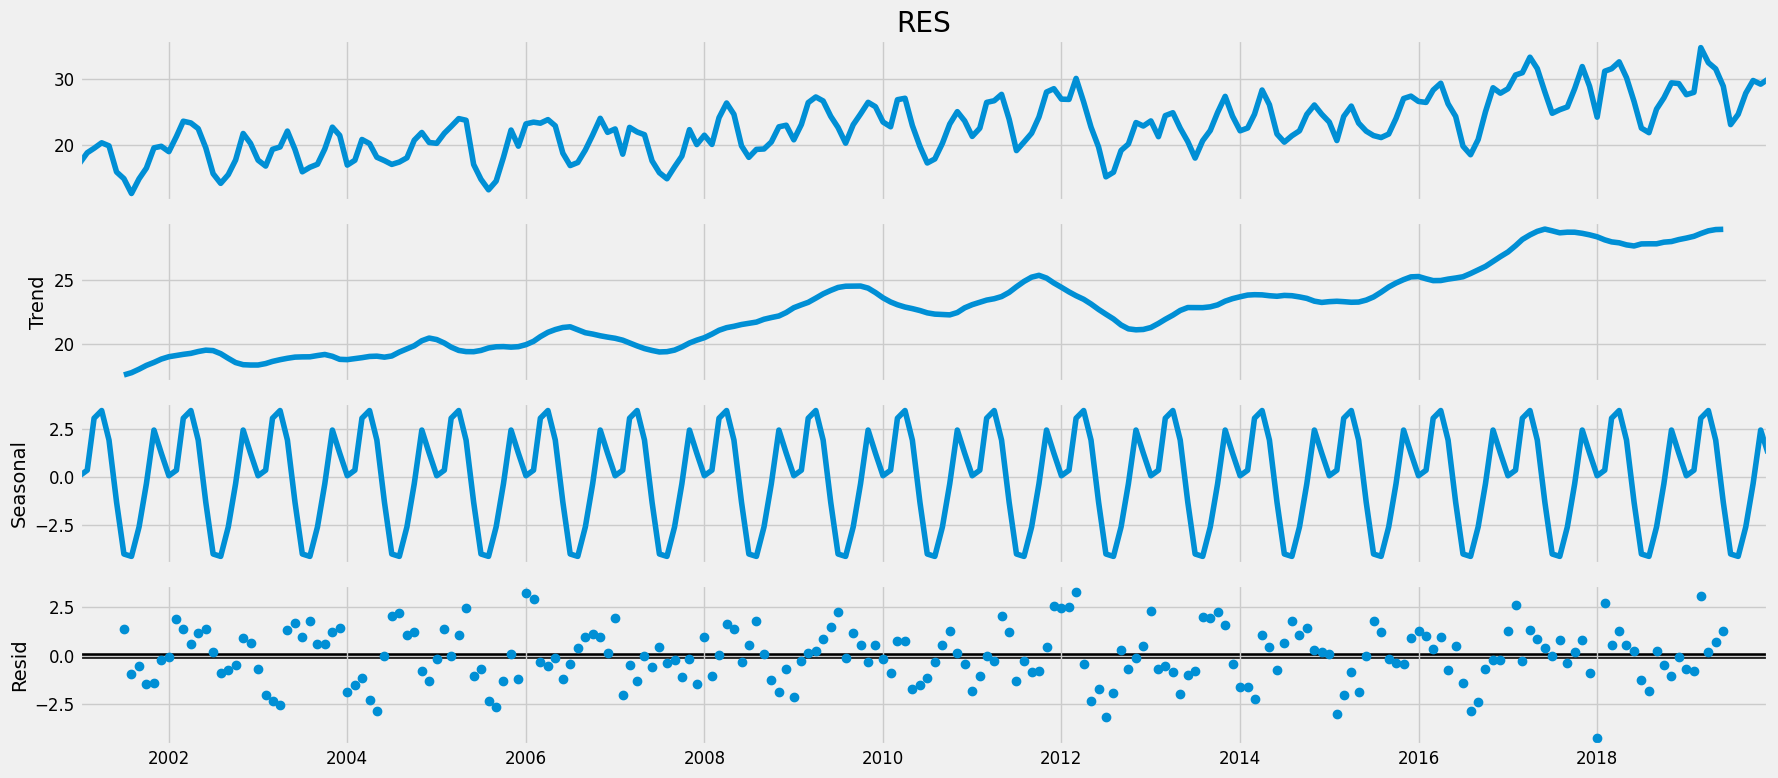

In [ ]:
y = state_data['RES'].resample('MS').sum()

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# **Monthly Time Series**

**Optimize ARIMA**

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:

  for param_seasonal in seasonal_pdq:
    try:
      mod = sm.tsa.statespace.SARIMAX(y, order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
      results = mod.fit()
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    except:
      continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2072.3884271151333
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1740.6314383048511
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1053.2583214496863
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:961.5204259181751
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1052.8024387183216
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:939.8575268899285
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:964.5280978697447
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:961.4828113553351
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1786.714111598593
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1491.8156820478025
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:946.8359052415815
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:855.2248233104661
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:954.040191949757
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:852.8175814770184
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:869.1959524050292
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:856.8020104842883
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1050.1165847022353
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:934.5062768368139
ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:888.8292493696049
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:778.7678369175433
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:884.0634550546981
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:807.3173149458008
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:810.9448194057595
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:780.7664671470425
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1037.2550618696432
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:935.0996237738366
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:886.5098332917291
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:765.862751853122
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:882.704726287011
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:803.4334491013042
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:811.3453694602722
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:767.8624659820721
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1039.7188266808262
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:934.7225924154909
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:908.5595881779168
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:771.8116547347765
ARIMA(1, 1

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:887.3458497095389
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:755.491282099674
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:861.2749656638177
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:806.1019844430525
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:809.263752475055
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:757.4912995435132


**Fit ARIMA**

Lowest AIC value at
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:757.4912995435132


In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1,1,1),
                                seasonal_order=(1,1,1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6412      0.065      9.897      0.000       0.514       0.768
ma.L1         -0.9528      0.030    -31.815      0.000      -1.011      -0.894
ar.S.L12   -9.805e-07      0.080  -1.23e-05      1.000      -0.156       0.156
ma.S.L12      -0.9444      0.138     -6.868      0.000      -1.214      -0.675
sigma2         2.1956      0.284      7.722      0.000       1.638       2.753


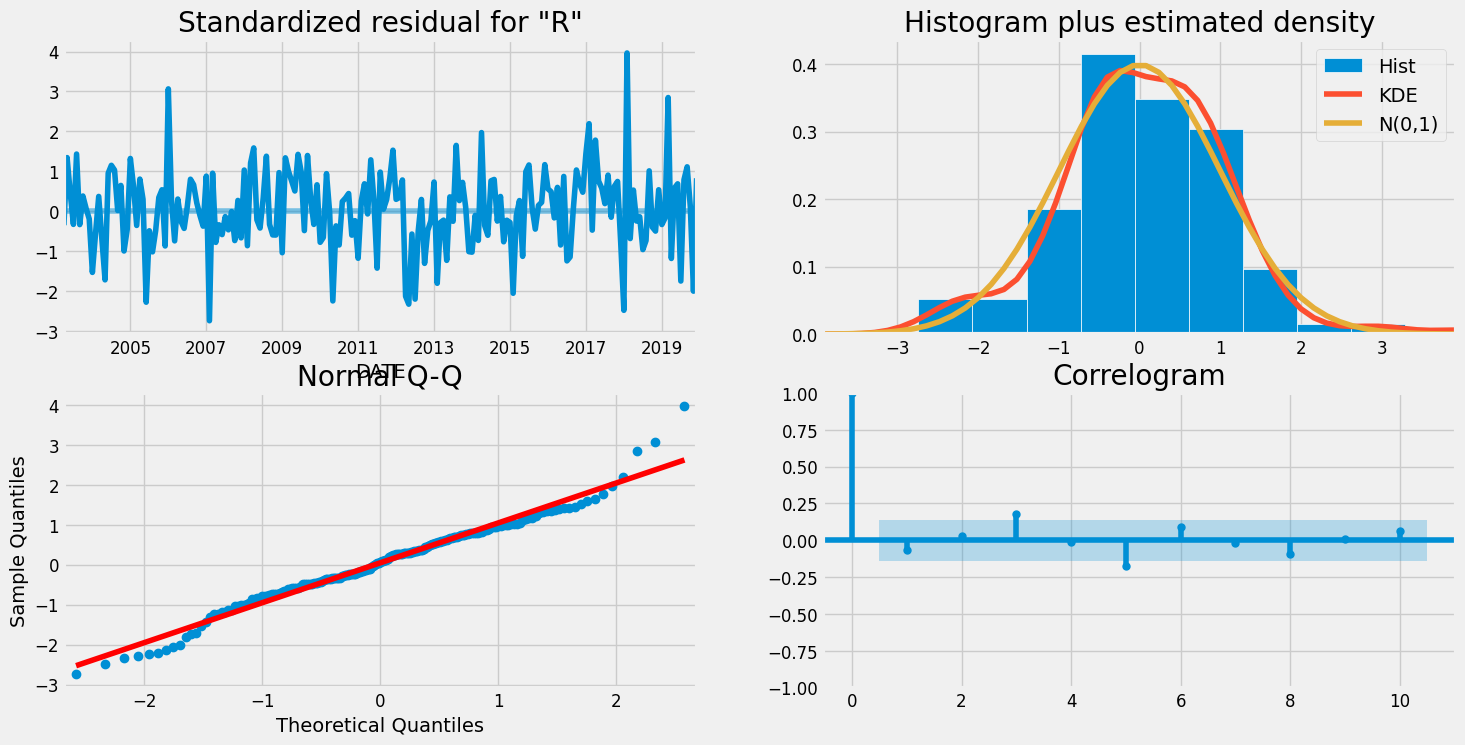

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

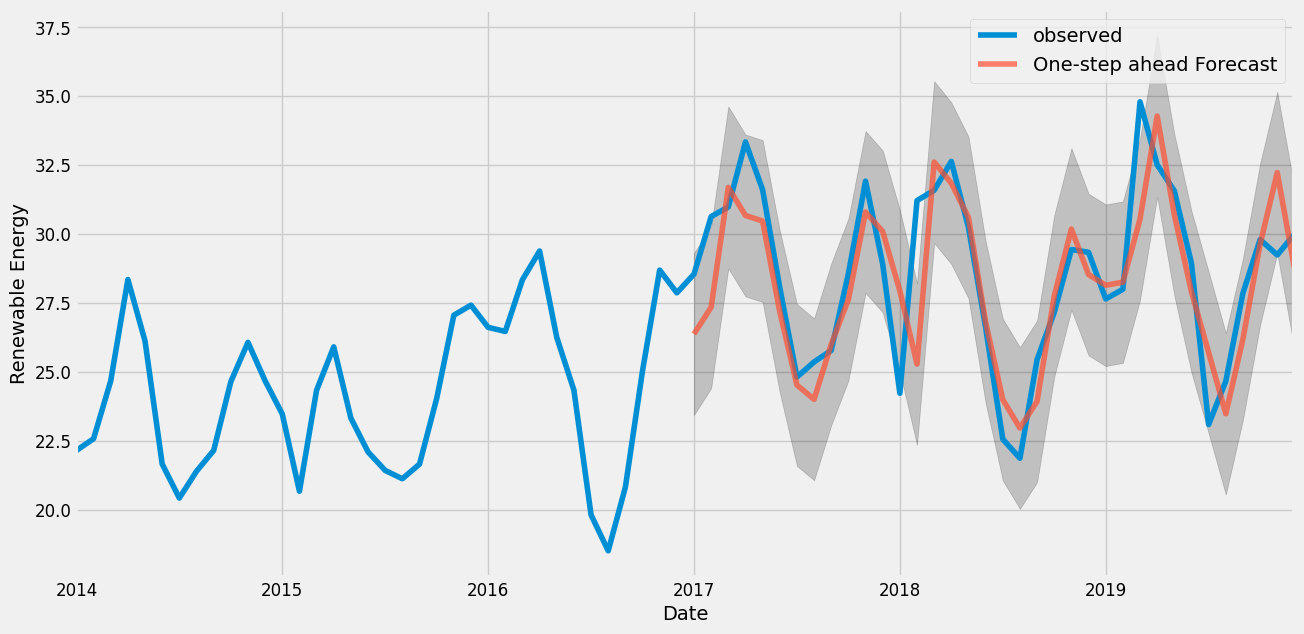

In [ ]:
#Validate forecasts

pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Renewable Energy')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 3.71
The Root Mean Squared Error of our forecasts is 1.93


# **Monthly Forecasting**

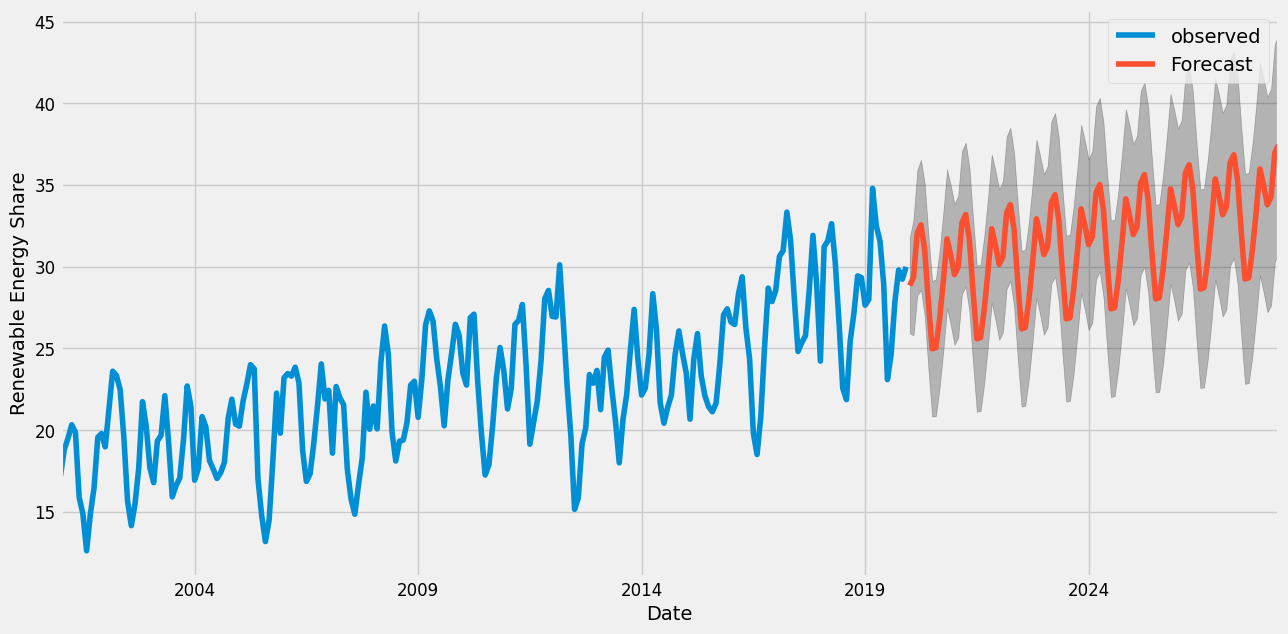

In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Renewable Energy Share')

plt.legend()
plt.show()

# **Yearly Forecasting**

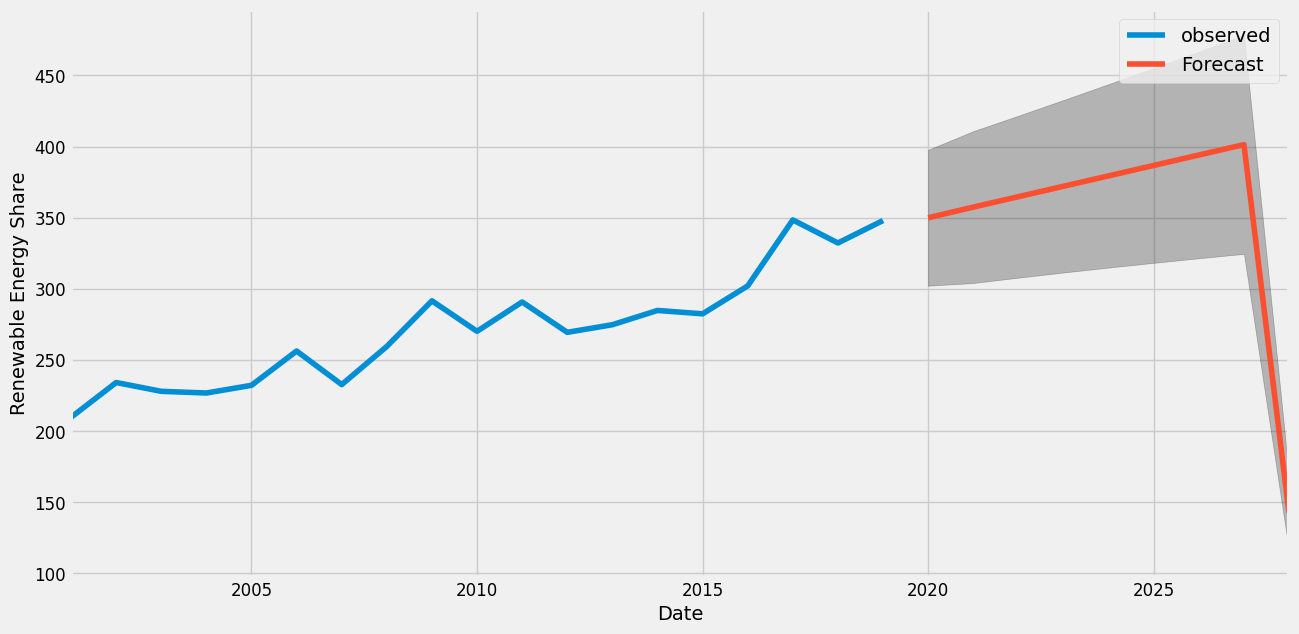

In [ ]:
yearly_sum = y.resample('Y').sum()

forecast_data = {
    'forecast': pred_uc.predicted_mean,  # The predicted values
    'lower_bound': pred_ci.iloc[:, 0],   # The lower bound of the confidence interval
    'upper_bound': pred_ci.iloc[:, 1]    # The upper bound of the confidence interval
}

# Convert the dictionary to a DataFrame and set the date index
df_forecast = pd.DataFrame(forecast_data, index=pred_uc.predicted_mean.index)

# Now, you can aggregate these monthly predictions to yearly
yearly_forecast = df_forecast.resample('Y').sum()

ax = yearly_sum.plot(label='observed', figsize=(14, 7))
yearly_forecast['forecast'].plot(ax=ax, label='Forecast')
ax.fill_between(yearly_forecast.index,
                yearly_forecast['lower_bound'],
                yearly_forecast['upper_bound'], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Renewable Energy Share')

plt.legend()
plt.show()

In [ ]:

yearly_sum.head()

DATE
2001-12-31    209.737720
2002-12-31    234.186284
2003-12-31    227.997455
2004-12-31    226.814323
2005-12-31    232.222520
Freq: A-DEC, Name: RES, dtype: float64